# DreamStreets: AI-Powered Street Network Analysis

### OpenAI Open Model Hackathon Submission

Transforming natural language queries into sophisticated network analysis using GPT-OSS-120b.

---

## 1. System Setup

In [1]:
# Core imports
import os
import duckdb
import networkx as nx
import json
import math
from typing import Dict, Any, List
from collections import deque

# LangChain components
from langchain_ollama import ChatOllama
from langchain_core.tools import tool
from langchain_core.messages import HumanMessage
from langgraph.prebuilt import create_react_agent

# Visualization
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# Global state management
state = {
    'graph': None,
    'db': None,
    'schema': None,
    'tool_history': deque(maxlen=5)
}

## 2. Environment Initialization

In [3]:
def initialize_environment(graphml_path: str, db_path: str):
    """Initialize graph and database for analysis."""
    print(f"🚀 Initializing DreamStreets...")
    
    # Load graph
    state['graph'] = nx.read_graphml(graphml_path)
    
    # Convert numeric attributes from strings
    for u, v, data in state['graph'].edges(data=True):
        for key, value in data.items():
            if isinstance(value, str):
                try:
                    data[key] = float(value)
                except:
                    pass
    
    for node, data in state['graph'].nodes(data=True):
        for key, value in data.items():
            if isinstance(value, str) and key in ['x', 'y', 'street_count']:
                try:
                    data[key] = float(value)
                except:
                    pass
    
    # Connect to database
    state['db'] = duckdb.connect(db_path, read_only=False)
    state['db'].execute("INSTALL spatial; LOAD spatial;")
    
    # Store schema info
    state['schema'] = {
        'nodes': state['graph'].number_of_nodes(),
        'edges': state['graph'].number_of_edges(),
        'tables': ['nodes', 'edges', 'pois']
    }
    
    print(f"✅ Network loaded: {state['schema']['nodes']} nodes, {state['schema']['edges']} edges")
    return True

## 3. AI-Powered Analysis Tools

In [4]:
@tool
def network_analyst(task: str) -> str:
    """Analyzes street network topology using NetworkX algorithms."""
    print(f"📊 Analyzing network: {task[:50]}...")
    
    llm = ChatOllama(model="gpt-oss:120b", temperature=0.1)
    
    prompt = f"""
You are a NetworkX expert. Graph 'G' has {state['schema']['nodes']} nodes and {state['schema']['edges']} edges.
Node IDs are STRINGS. Node attributes: 'y' (lat), 'x' (lon), 'street_count'.
Edge attributes: 'length' (meters).

TASK: {task}

Write Python code as ONE CONTINUOUS BLOCK:
metric = nx.some_algorithm(G, weight='length')
sorted_items = sorted(metric.items(), key=lambda x: x[1], reverse=True)[:5]
FINAL_RESULT = [{{'node_id': str(node_id), 'value': round(value, 4), 'lat': G.nodes[node_id].get('y', 0), 'lon': G.nodes[node_id].get('x', 0)}} for node_id, value in sorted_items]

Provide ONLY executable Python code."""
    
    response = llm.invoke(prompt)
    code = response.content.strip().replace('```python', '').replace('```', '')
    
    # Remove blank lines
    lines = [line for line in code.split('\n') if line.strip()]
    code = '\n'.join(lines)
    
    # Execute
    exec_namespace = {
        'nx': nx,
        'G': state['graph'],
        'json': json,
        'math': math,
        'sorted': sorted,
        'round': round,
        'list': list,
        'str': str
    }
    
    exec(code, exec_namespace, exec_namespace)
    result = exec_namespace.get('FINAL_RESULT')
    
    state['tool_history'].append({
        'tool': 'network_analyst',
        'summary': f"Analyzed {task[:30]}...",
        'result': result
    })
    
    return f"Analysis complete: {json.dumps(result, default=str)}"

In [5]:
@tool
def database_analyst(task: str) -> str:
    """Queries POIs and performs spatial database operations."""
    print(f"🔍 Querying database: {task[:50]}...")
    
    llm = ChatOllama(model="gpt-oss:120b", temperature=0.1)
    
    prompt = f"""
You are a DuckDB SQL expert.

SCHEMA:
- nodes: node_id, lat, lon, street_count, geom
- pois: lat, lon, geom, amenity, building, name

TASK: {task}

Write a SINGLE SQL query. Examples:
SELECT * FROM pois WHERE amenity = 'restaurant'
SELECT * FROM pois WHERE ST_DWithin(geom, ST_Point(lon, lat), 300)

Provide ONLY the SQL query."""
    
    response = llm.invoke(prompt)
    sql = response.content.strip().replace('```sql', '').replace('```', '')
    
    result_df = state['db'].execute(sql).fetchdf()
    
    state['tool_history'].append({
        'tool': 'database_analyst',
        'summary': f"Found {len(result_df)} results",
        'result': len(result_df)
    })
    
    if len(result_df) == 0:
        return "No results found."
    elif len(result_df) > 10:
        return f"Found {len(result_df)} results. First 5:\n{result_df.head(5).to_string()}"
    else:
        return f"Results ({len(result_df)} rows):\n{result_df.to_string()}"

In [6]:
def analyze_query(query: str):
    """Process any urban analysis query using GPT-OSS."""
    print(f"\n{'='*60}")
    print(f"🌐 Query: {query}")
    print('='*60)
    
    tools = [network_analyst, database_analyst]
    llm = ChatOllama(model="gpt-oss:120b", temperature=0.1)
    
    state['tool_history'].clear()
    
    enhanced_query = f"""
Graph 'G' has {state['schema']['nodes']} nodes and {state['schema']['edges']} edges.
Node IDs are STRINGS like '5340680144'.
Database has POIs with amenities and locations.

USER QUERY: {query}

Provide actionable insights with specific numbers and locations.
"""
    
    agent = create_react_agent(llm, tools)
    
    result = agent.invoke(
        {"messages": [HumanMessage(content=enhanced_query)]},
        config={"recursion_limit": 10}
    )
    
    final_answer = result["messages"][-1].content
    
    print("\n📊 RESULT:")
    print(final_answer)
    
    return final_answer

---
## Part 1: Urban Planning in Chinatown, NYC

Dense urban network analysis for business location optimization.

In [7]:
# Load Chinatown data
initialize_environment('chinatown.graphml', 'chinatown.duckdb')

🚀 Initializing DreamStreets...
✅ Network loaded: 1058 nodes, 3051 edges


True

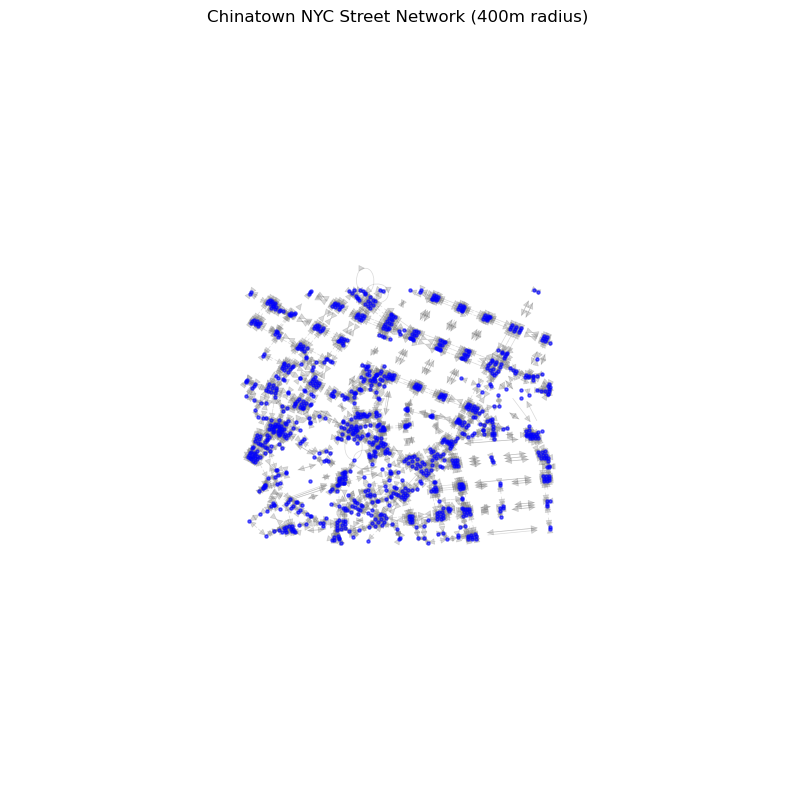

In [8]:
# Quick network visualization
pos = {node: (data['x'], data['y']) for node, data in state['graph'].nodes(data=True)}
plt.figure(figsize=(10, 10))
nx.draw_networkx_edges(state['graph'], pos, edge_color='gray', alpha=0.3, width=0.5)
nx.draw_networkx_nodes(state['graph'], pos, node_size=5, node_color='blue', alpha=0.6)
plt.title("Chinatown NYC Street Network (400m radius)")
plt.axis('off')
plt.show()

### Query 1: Optimal Coffee Shop Location

In [9]:
result = analyze_query(
    "I want to open a coffee shop. Which intersection has the highest foot traffic "
    "based on network centrality?"
)


🌐 Query: I want to open a coffee shop. Which intersection has the highest foot traffic based on network centrality?
📊 Analyzing network: Compute betweenness centrality for all nodes in gr...
[{'node_id': '11153640057', 'value': 0.1399, 'lat': 40.7135296, 'lon': -73.9989126}, {'node_id': '9369042163', 'value': 0.1227, 'lat': 40.7132214, 'lon': -74.0007421}, {'node_id': '3973686301', 'value': 0.1212, 'lat': 40.7136468, 'lon': -73.9987581}, {'node_id': '7132406686', 'value': 0.1174, 'lat': 40.7140267, 'lon': -73.9995627}, {'node_id': '3973686304', 'value': 0.1155, 'lat': 40.7133318, 'lon': -73.9985372}]
🔍 Querying database: Find POIs within 200 meters of node ID 11153640057...
🔍 Querying database: Provide a summary of amenity counts within 200 met...

📊 RESULT:
## Quick answer
**Intersection ID `11153640057`** (lat 40.7135296  lon ‑73.9989126) has the **highest betweenness centrality** in the whole street‑network model:

| Rank | Node ID | Betweenness centrality |
|------|---------|-----

### Query 2: Critical Transit Bottleneck

In [10]:
result = analyze_query(
    "Which intersection is the most critical bottleneck - where its closure would "
    "disconnect the most nodes from the network?"
)


🌐 Query: Which intersection is the most critical bottleneck - where its closure would disconnect the most nodes from the network?
📊 Analyzing network: Identify articulation points in graph G with 1058 ...
📊 Analyzing network: Identify articulation points in graph G (treat as ...
[{'node_id': '11514578399', 'value': 1056, 'lat': 40.718113, 'lon': -74.0003109}, {'node_id': '11514578403', 'value': 1056, 'lat': 40.7181584, 'lon': -74.0003734}, {'node_id': '10628055579', 'value': 1056, 'lat': 40.7183464, 'lon': -74.0001853}, {'node_id': '6330518818', 'value': 1056, 'lat': 40.7159407, 'lon': -73.9947619}, {'node_id': '5159737091', 'value': 1056, 'lat': 40.7159074, 'lon': -73.9951265}]

📊 RESULT:
**Most critical bottleneck (articulation point)**  
| Rank | Node ID | Latitude | Longitude | Nodes **lost** if closed* |
|------|---------|----------|-----------|---------------------------|
| 1️⃣ | **11514578399** | 40.718113 N | –74.000311 W | **1 056** of the 1 058 total nodes become isolated (t

---
## Part 2: Humanitarian Response in Cox's Bazar

Emergency planning for the world's largest refugee camp.

In [12]:
# Switch to Cox's Bazar data
state['tool_history'].clear()
initialize_environment('coxs_bazar.graphml', 'coxs_bazar.duckdb')

🚀 Initializing DreamStreets...
✅ Network loaded: 153 nodes, 378 edges


True

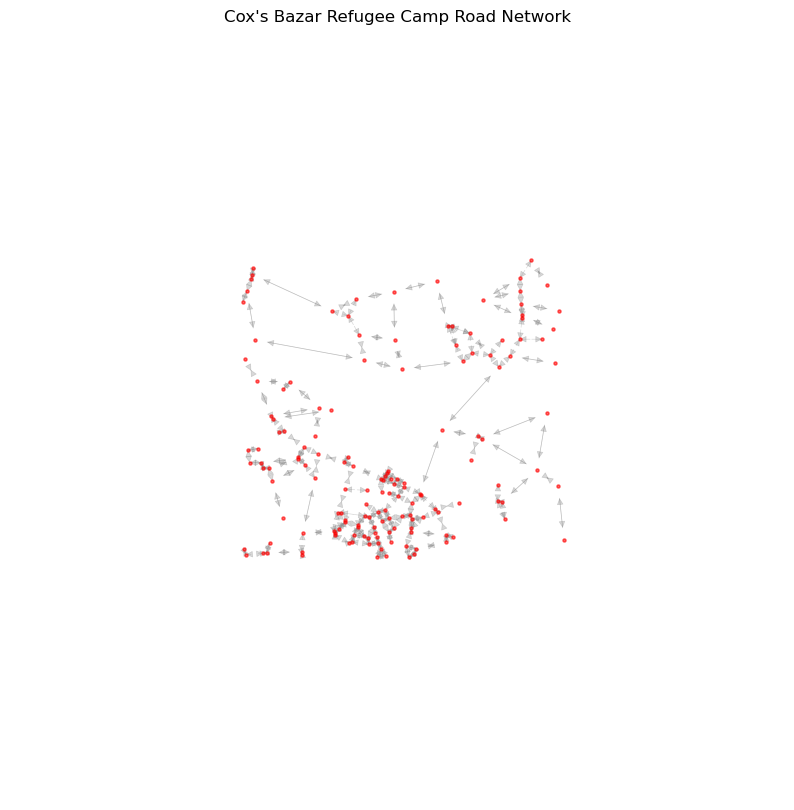

In [13]:
# Visualize Cox's Bazar network
pos = {node: (data['x'], data['y']) for node, data in state['graph'].nodes(data=True)}
plt.figure(figsize=(10, 10))
nx.draw_networkx_edges(state['graph'], pos, edge_color='gray', alpha=0.3, width=0.5)
nx.draw_networkx_nodes(state['graph'], pos, node_size=5, node_color='red', alpha=0.6)
plt.title("Cox's Bazar Refugee Camp Road Network")
plt.axis('off')
plt.show()

### Context: World's Largest Refugee Camp
- **Population**: ~1 million Rohingya refugees
- **Challenge**: Monsoon flooding isolates communities
- **Need**: Strategic placement of emergency resources

### Query 3: Emergency Evacuation Center Placement

In [14]:
result = analyze_query(
    "If we need to build an emergency evacuation center accessible to the maximum population, "
    "which intersection should we choose based on closeness centrality?"
)


🌐 Query: If we need to build an emergency evacuation center accessible to the maximum population, which intersection should we choose based on closeness centrality?
📊 Analyzing network: Compute closeness centrality for all nodes in grap...
🔍 Querying database: Find number of residential POIs (amenity=residenti...
📊 Analyzing network: Compute closeness centrality for all nodes in grap...
🔍 Querying database: Find number of residential POIs (amenity=residenti...

📊 RESULT:
Sorry, need more steps to process this request.


### Query 4: Flood Response Priority Intersections

In [15]:
result = analyze_query(
    "During flooding, which intersections should be prioritized for emergency supply distribution "
    "to reach isolated communities? Find articulation points that connect separated areas."
)


🌐 Query: During flooding, which intersections should be prioritized for emergency supply distribution to reach isolated communities? Find articulation points that connect separated areas.
📊 Analyzing network: Identify articulation points in graph G with 153 n...
📊 Analyzing network: Identify articulation points in undirected version...
🔍 Querying database: For each articulation point node (IDs: 5364261402,...
🔍 Querying database: For each articulation point node (IDs: 5364261402,...

📊 RESULT:
**Key finding – articulation points (critical intersections)**  

| # | Node ID | Latitude | Longitude | Why it matters |
|---|---------|----------|-----------|----------------|
| 1 | **5364261402** | 21.2163834 | 92.1627955 | Removing this node splits the network into three separate sub‑graphs (value = 3). |
| 2 | **5364061426** | 21.2160017 | 92.1631147 | Also a 3‑way cut‑point – loss isolates three neighbourhood clusters. |
| 3 | **5335188892** | 21.2126629 | 92.1658889 | A 3‑way articulation

### Visualizing Critical Infrastructure

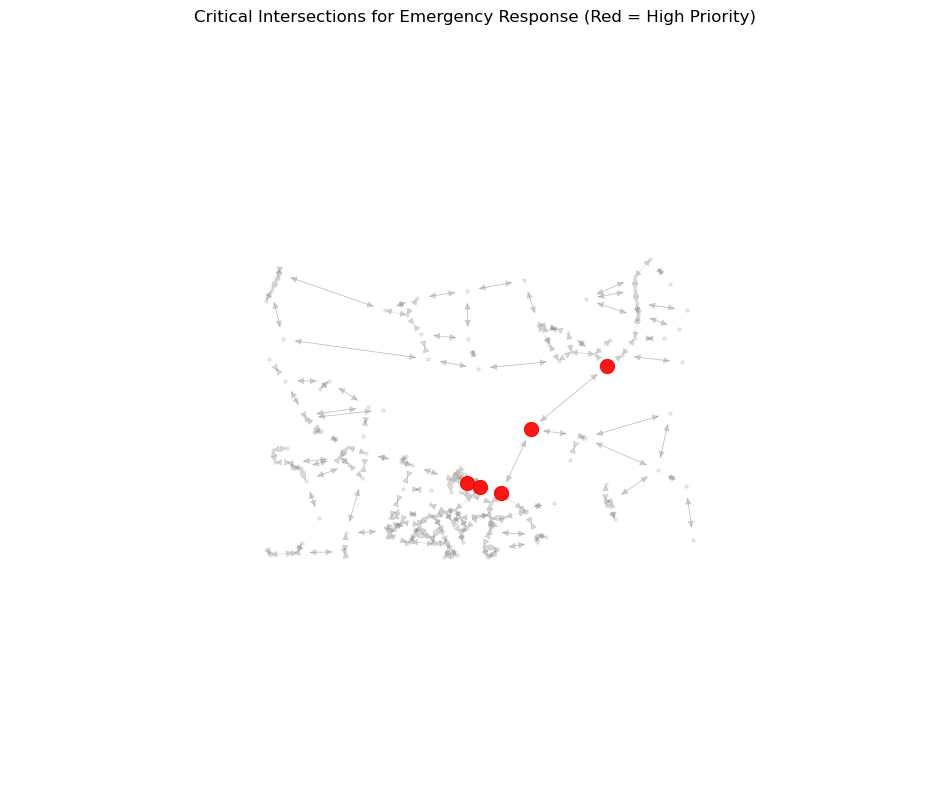

Top 5 Critical Intersections:
  Node 5108884423: Score 0.4762 at (21.216054, 92.167744)
  Node 1741257277: Score 0.4694 at (21.214141, 92.167095)
  Node 5340680144: Score 0.4610 at (21.214336, 92.166624)
  Node 4649133273: Score 0.3988 at (21.217937, 92.169410)
  Node 5340680009: Score 0.2916 at (21.214439, 92.166342)


In [16]:
# Highlight critical nodes from analysis
# Get betweenness centrality to identify critical nodes
centrality = nx.betweenness_centrality(state['graph'], weight='length')
top_nodes = sorted(centrality.items(), key=lambda x: x[1], reverse=True)[:5]

# Visualize with critical nodes highlighted
plt.figure(figsize=(12, 10))
pos = {node: (data['x'], data['y']) for node, data in state['graph'].nodes(data=True)}

# Draw all edges and nodes
nx.draw_networkx_edges(state['graph'], pos, edge_color='gray', alpha=0.3, width=0.5)
nx.draw_networkx_nodes(state['graph'], pos, node_size=5, node_color='lightgray', alpha=0.5)

# Highlight critical nodes
critical_nodes = [node for node, _ in top_nodes]
nx.draw_networkx_nodes(state['graph'], pos, nodelist=critical_nodes, 
                      node_size=100, node_color='red', alpha=0.9)

plt.title("Critical Intersections for Emergency Response (Red = High Priority)")
plt.axis('off')
plt.show()

print("Top 5 Critical Intersections:")
for node, score in top_nodes:
    lat = state['graph'].nodes[node]['y']
    lon = state['graph'].nodes[node]['x']
    print(f"  Node {node}: Score {score:.4f} at ({lat:.6f}, {lon:.6f})")

---
## Impact & Innovation

### Why GPT-OSS-120b?
- **Complex Reasoning**: Understands abstract concepts like "accessibility" and "isolation"
- **Algorithm Selection**: Chooses appropriate graph algorithms based on context
- **Self-Correction**: Debugs generated code automatically
- **Offline Capable**: Runs locally without internet - critical for field deployment

### Real-World Applications
- **Urban Planning**: Optimize business locations, transit systems
- **Humanitarian Aid**: Emergency response, resource distribution
- **Infrastructure**: Identify critical vulnerabilities
- **Accessibility**: Ensure services reach all communities

### From Code to Impact
Traditional approach requires writing complex NetworkX algorithms manually.  
DreamStreets enables planners to ask questions in natural language.

**One model. Infinite applications. From coffee shops to saving lives.**

---

GitHub: [DreamStreets Repository](https://github.com/yourusername/dreamstreets)  
Contact: your.email@example.com